In [68]:
import pickle

with open("/Users/anuraagsrivatsa/Documents/Capstone/EAV/EAV/processed_data_psd/subject40_processed_psd.pkl", "rb") as f:
    subject1_eeg_features = pickle.load(f)

print(subject1_eeg_features["features"].shape)
print(subject1_eeg_features["labels"].shape)

(400, 30, 5)
(400, 5)


In [69]:
tr_1 = subject1_eeg_features["features"][0]
tr_1.shape


(30, 5)

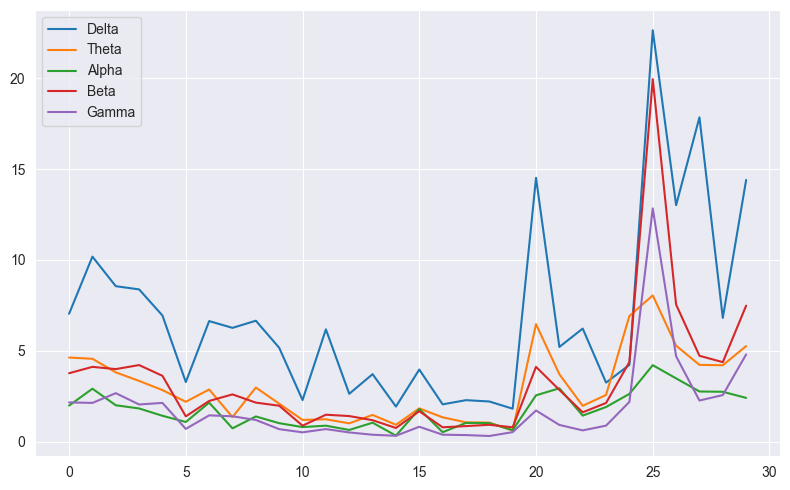

In [70]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (8,5))
band_names = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
for i in range(tr_1.shape[1]):
    plt.plot(tr_1[:,i], label = band_names[i])
plt.legend()
plt.tight_layout()
plt.grid(True)

In [71]:
X = subject1_eeg_features["features"]
y = subject1_eeg_features["labels"]

num_classes = y.shape[1]
train_ratio = 0.7  # 70% train

X_train_list, y_train_list = [], []
X_test_list, y_test_list   = [], []

for class_idx in range(num_classes):
    # Find indices of this class
    class_mask = np.where(y[:, class_idx] == 1)[0]

    # Shuffle indices
    class_mask = np.random.permutation(class_mask)

    # Split indices
    n_train = int(len(class_mask) * train_ratio)
    train_idx = class_mask[:n_train]
    test_idx  = class_mask[n_train:]

    # Append samples
    X_train_list.append(X[train_idx])
    y_train_list.append(y[train_idx])
    X_test_list.append(X[test_idx])
    y_test_list.append(y[test_idx])

# Concatenate all classes
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test  = np.concatenate(X_test_list, axis=0)
y_test  = np.concatenate(y_test_list, axis=0)

# Shuffle the combined train/test sets
train_perm = np.random.permutation(len(X_train))
test_perm  = np.random.permutation(len(X_test))

X_train, y_train = X_train[train_perm], y_train[train_perm]
X_test, y_test   = X_test[test_perm], y_test[test_perm]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape: ", X_test.shape, y_test.shape)

Train shape: (280, 30, 5) (280, 5)
Test shape:  (120, 30, 5) (120, 5)


In [72]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
tf.keras.backend.clear_session()

# num_classes = 5
# l2_penalty = 0.001 # A good starting point for the regularization strength
#
# model = models.Sequential([
#     layers.Input(shape=(30, 5, 1)),
#
#     # Added L2 regularization to penalize large weights
#     layers.Conv2D(16, (3,3), activation='relu', padding='same',
#                   kernel_regularizer=regularizers.l2(l2_penalty)), # <-- CHANGE
#
#     layers.BatchNormalization(),
#
#     # Added L2 regularization here as well
#     layers.Conv2D(32, (3,3), activation='relu', padding='same',
#                   kernel_regularizer=regularizers.l2(l2_penalty)), # <-- CHANGE
#
#     layers.BatchNormalization(),
#
#     # Using (2,1) pooling to only downsample across channels, not features
#     layers.MaxPooling2D((2, 1)), # <-- CHANGE
#
#     # Increased dropout rate for stronger regularization
#     layers.Dropout(0.4), # <-- CHANGE
#
#     layers.Flatten(),
#
#     # Added L2 regularization to the dense layer
#     layers.Dense(64, activation='relu',
#                  kernel_regularizer=regularizers.l2(l2_penalty)), # <-- CHANGE
#
#     # Increased dropout rate here as well
#     layers.Dropout(0.4), # <-- CHANGE
#
#     layers.Dense(num_classes, activation='softmax')
# ])
#
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

def EEGNet_Corrected(num_classes=5, F1=8, D=2, F2=16, dropout_rate=0.5, l2_penalty=0.001):
    """
    A corrected and regularized EEGNet for smaller datasets.
    Fixes the kernel_regularizer argument for depthwise and separable layers.
    """
    inputs = layers.Input(shape=(30, 5, 1))

    # Define the regularizer
    reg = regularizers.l2(l2_penalty)

    # Block 1: Temporal and Spatial Filtering
    # ------------------------------------------
    # Conv2D uses 'kernel_regularizer'
    x = layers.Conv2D(F1, (1, 5), padding='same', use_bias=False, kernel_regularizer=reg)(inputs)
    x = layers.BatchNormalization()(x)

    # DepthwiseConv2D uses 'depthwise_regularizer' -- THIS IS THE FIX
    x = layers.DepthwiseConv2D((30, 1), use_bias=False, depth_multiplier=D, padding='valid',
                               depthwise_regularizer=reg)(x) # <-- FIX HERE
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)
    x = layers.AveragePooling2D((1, 2))(x)
    x = layers.Dropout(dropout_rate)(x)

    # Block 2: Separable Convolution
    # ------------------------------------------
    # SeparableConv2D has two regularizers: 'depthwise_regularizer' and 'pointwise_regularizer'
    x = layers.SeparableConv2D(F2, (1, 3), padding='same', use_bias=False,
                               depthwise_regularizer=reg,
                               pointwise_regularizer=reg)(x) # <-- FIX HERE
    x = layers.BatchNormalization()(x)
    x = layers.Activation('elu')(x)

    x = layers.Flatten()(x)

    # Classifier Block
    # ------------------------------------------
    # Dense layer uses 'kernel_regularizer'
    outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=reg)(x)

    model = models.Model(inputs, outputs)
    return model

# --- How to create and compile it ---
model = EEGNet_Corrected(num_classes=5, dropout_rate=0.6, l2_penalty=0.01)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 5, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 5, 8)       │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 5, 8)       │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 5, 16)       │           480 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 5, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 2, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 2, 16)       │           304 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 2, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,149 (4.49 KB)

 Trainable params: 1,069 (4.18 KB)

 Non-trainable params: 80 (320.00 B)

In [73]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
early_stopper = EarlyStopping(monitor='val_accuracy', mode='max', patience=25, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test, y_test), callbacks=[early_stopper])


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.2071 - loss: 2.1219 - val_accuracy: 0.2250 - val_loss: 1.9228
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2500 - loss: 2.1155 - val_accuracy: 0.2167 - val_loss: 1.9176
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1893 - loss: 2.0042 - val_accuracy: 0.2417 - val_loss: 1.9129
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2679 - loss: 1.9862 - val_accuracy: 0.2500 - val_loss: 1.9084
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2429 - loss: 1.9188 - val_accuracy: 0.2500 - val_loss: 1.9039
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2857 - loss: 1.8736 - val_accuracy: 0.2250 - val_loss: 1.8995
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3071 - loss: 1.8713 - val_accuracy: 0.2083 - val_loss: 1.8952
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2857 - loss: 1.8426 - val_accuracy: 0.2000 - val_loss: 1.8906
Epoch 9

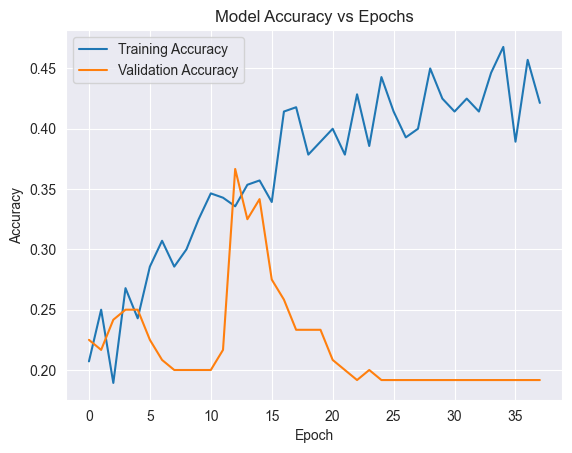

In [74]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
# You can access the recorded values like this:
history_dict = history.history

# Plot training & validation accuracy values
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3083 - loss: 1.8582 
Test Loss: 1.8582, Test Accuracy: 0.3083
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:
 [[ 0 18  0  5  1]
 [ 0 23  0  1  0]
 [ 0 13  0 11  0]
 [ 1  9  0 14  0]
 [ 0 22  1  1  0]]

Classification Report:

              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00        24
     Sadness       0.27      0.96      0.42        24
       Anger       0.00      0.00      0.00        24
       Happy       0.44      0.58      0.50        24
        Calm       0.00      0.00      0.00        24

    accuracy                           0.31       120
   macro avg       0.14      0.31      0.18       120
weighted avg       0.14      0.31      0.18       120



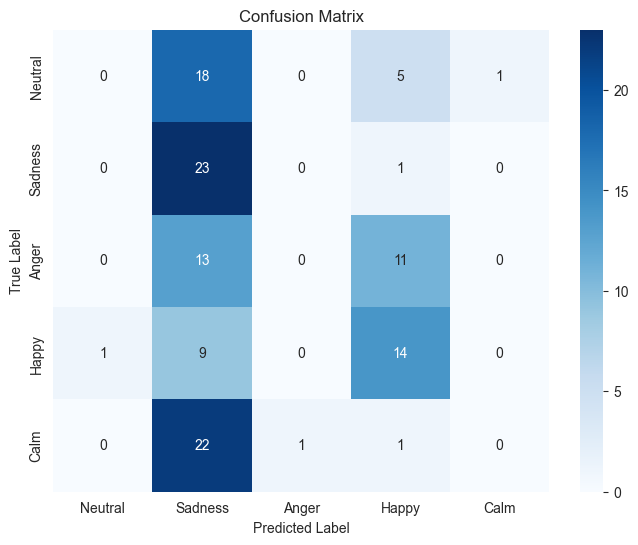

In [67]:
# ---- 1. Predict classes ----
# y_test: one-hot encoded labels, shape (num_samples, 5)
# model: trained Keras model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # predicted class indices
y_true = np.argmax(y_test, axis=1)        # true class indices

# ---- 2. Confusion matrix ----
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# ---- 3. Classification report ----
target_names = ['Neutral', 'Sadness', 'Anger', 'Happy', 'Calm']
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

# ---- 4. Plot confusion matrix heatmap ----
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [44]:
print(np.sum(y_pred, axis=0) / len(y_pred))

2.025


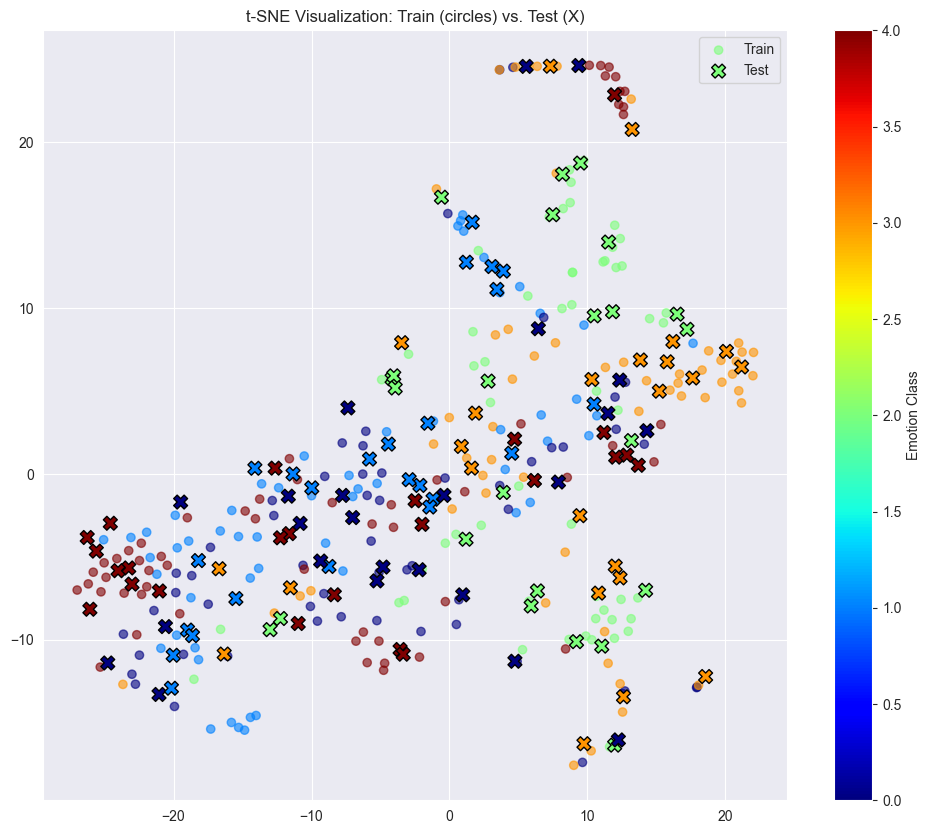

In [46]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# --- Setup ---
# 1. Make sure you have the data *before* the final shuffle
#    (i.e., X_train_raw, y_train_raw, X_test_raw, y_test_raw)
#    This is just to make the plot labels cleaner.

# 2. Combine them for the t-SNE
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# 3. Create a label for "train" vs "test"
#    (1 for train, 0 for test)
train_test_labels = np.array([1] * len(X_train) + [0] * len(X_test))

# 4. We need to flatten the (30, 5) features into a 150-dim vector
X_flattened = X_combined.reshape(X_combined.shape[0], -1)

# --- Run t-SNE ---
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_flattened)

# --- Plot the results ---
plt.figure(figsize=(12, 10))

# Plot Train data
train_idx = (train_test_labels == 1)
plt.scatter(X_tsne[train_idx, 0], X_tsne[train_idx, 1],
            c=np.argmax(y_combined[train_idx], axis=1),
            cmap='jet', marker='o', alpha=0.6, label='Train')

# Plot Test data (with a different marker)
test_idx = (train_test_labels == 0)
plt.scatter(X_tsne[test_idx, 0], X_tsne[test_idx, 1],
            c=np.argmax(y_combined[test_idx], axis=1),
            cmap='jet', marker='X', s=100, edgecolor='black', label='Test')

plt.title('t-SNE Visualization: Train (circles) vs. Test (X)')
plt.legend()
plt.colorbar(label='Emotion Class')
plt.show()

In [47]:
# After training
final_layer = model.layers[-1]
weights, biases = final_layer.get_weights()

print("Final Layer Biases:")
print(biases)

# Assuming 'angry' is class index 0
# print(f"Bias for 'angry': {biases[0]}")

Final Layer Biases:
[-0.01241107 -0.03901141  0.0351611   0.01885548 -0.0047587 ]
